In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

In [3]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')
env.call('../002_design_optics/quad_strength_limits.py')

env.call('../002_design_optics/matching_constraints.py')

In [4]:
line = -env['ccs_yl'] + (-env['ccs_xl'])

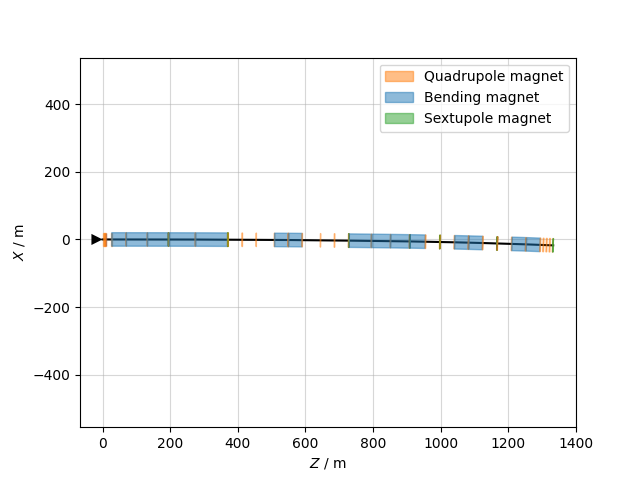

In [5]:
line.survey().plot()

In [6]:
env.vars.load_json('strengths_quads_01_ffccsyl.json')

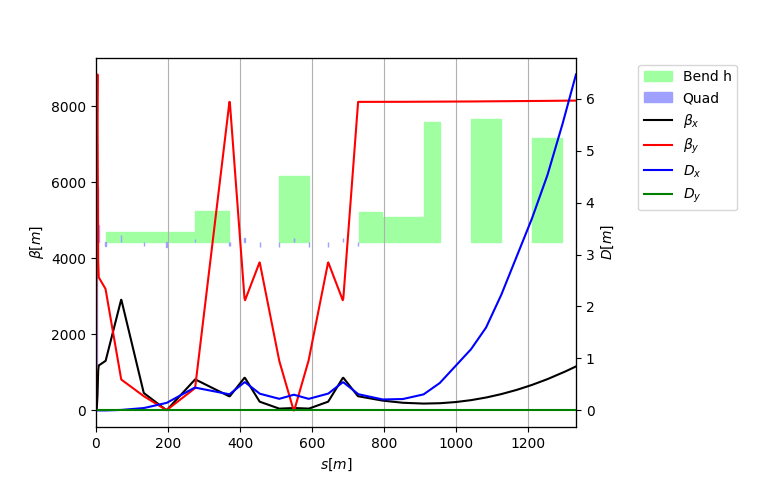

In [7]:
line.twiss(betx=env['bxip'], bety=env['byip']).plot()

In [8]:
kq_section_c = ['kqd07l', 'kqf08l', 'kqd09l', 'kqf10l']
kq_section_d = ['kqd11l', 'kqf12l']
kq_xquads =    ['kqx00l', 'kqx01l', 'kqx02l']
kq_section_e = ['kqf13l', 'kqd14l', 'kqf15l', 'kqd16l',
                   'kqf17l', 'kqd18l', 'kqf19l', 'kqd20l']

In [9]:
# Initialize quadrupoles with a small strength
for nn in kq_section_c + kq_section_d + kq_xquads + kq_section_e:
    if line.vars.vary_default[nn]['limits'][1] > 1e-3: # Focusing quad
        line[nn] = 1e-3
    else: # Defocusing quad
        line[nn] = -1e-3

In [10]:
opt_ipimag3 = line.match(
    name='imag3',
    solve=False,
    betx=env['bxip'], bety=env['byip'],
    vary=xt.VaryList(kq_section_c, step=1e-10),
    targets=[
        xt.TargetSet(betx=xt.LessThan(27.0),
                     bety=xt.LessThan(15.0),
                     alfx=xt.GreaterThan(0.),
                     alfy=xt.GreaterThan(0.5),
                     dx=xt.GreaterThan(0.235),
                     at='sfm2l::0'),
        xt.TargetSet(alfy=xt.LessThan(0.9), dx=xt.LessThan(0.25),
                     at='sfm2l::0')])
opt = opt_ipimag3

In [11]:
opt.step(20)
opt.run_simplex(1000)

                                             
Optimize [imag3] - start penalty: 7856  
Matching: model call n. 183               
Optimize [imag3] - end penalty:  279.441
                                             
Optimize [imag3] - start penalty: 279.4   
Matching: model call n. 299                                  
Optimize [imag3] - end penalty:     0


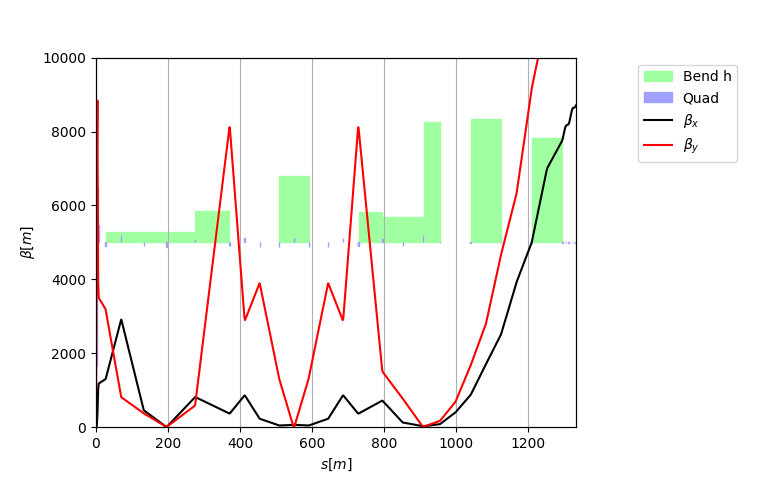

In [12]:
pp=opt.plot('betx bety')
pp.ylim(left_lo=0, left_hi=10000)

In [13]:
opt_sfx1l = opt_ipimag3.clone(name='sfx1l_d',
          remove_vary=True,
          add_vary=xt.VaryList(kq_section_d, step=1e-10),
          add_targets=xt.TargetSet(betx=xt.GreaterThan(1000.),
             alfx=0,
             bety=xt.LessThan(45.),
             dx=xt.LessThan(0.6),
             mux=1.75 - 0.0093,
             at='sfx1l::1'))
opt = opt_sfx1l

In [14]:
opt.step(20)

                                             
Optimize [sfx1l_d] - start penalty: 878.5
Matching: model call n. 116               
Optimize [sfx1l_d] - end penalty:  0.49943


In [15]:
opt_sfx1l_cd = opt_sfx1l.clone(
    name='sfx1l_cd',
    add_vary=opt_ipimag3.vary)
opt = opt_sfx1l_cd

In [16]:
opt.step(20)

                                             
Optimize [sfx1l_cd] - start penalty: 0.4994
Matching: model call n. 75               
Optimize [sfx1l_cd] - end penalty:  2.45847e-11


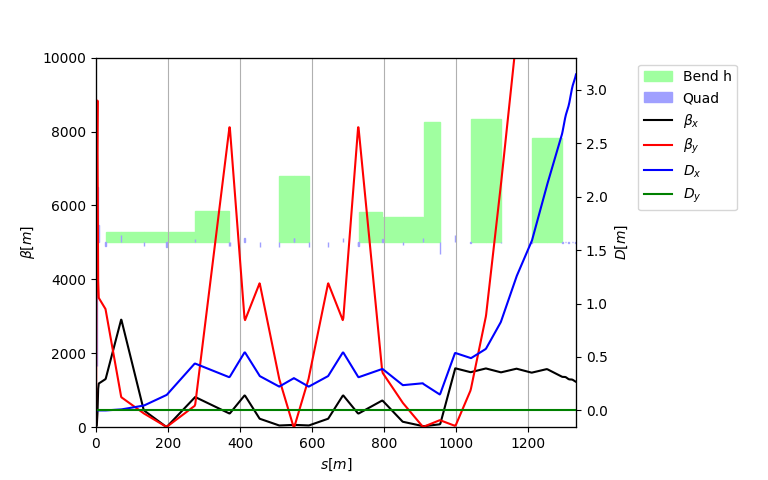

In [17]:
pp=opt.plot()
pp.ylim(left_lo=0, left_hi=10000)

In [18]:
# Match r matrix alone
opt_rsext = line.match(
    name='rmat_sext',
    solve=False,
    start='sfx1l::1', end='sfx2l::1',
    init_at='ipimag4',
    betx=0.20, bety=0.20, # Rough estimate
    targets=xt.TargetRmatrix(start='sfx1l::1', end='sfx2l::1',
                r12=env['r12_ccsxl'], r34=env['r34_ccsxl'],
                r11=-1, r33=-1),
    vary=xt.VaryList(kq_xquads, step=1e-10)
)

opt = opt_rsext
opt.disable(target=True)
opt.enable(target=0)
opt.step(20)
opt.enable(target=1)
opt.step(20)
opt.enable(target=2)
opt.step(20)
opt.enable(target=3)
opt.step(20)

                                             
Optimize [rmat_sext] - start penalty: 1.991
Matching: model call n. 41               
Optimize [rmat_sext] - end penalty:  3.88578e-15
                                             
Optimize [rmat_sext] - start penalty: 34.15
Matching: model call n. 162               
Optimize [rmat_sext] - end penalty:  3.04563e-08
                                             
Optimize [rmat_sext] - start penalty: 7.971
Matching: model call n. 308               
Optimize [rmat_sext] - end penalty:  0.00207779
                                             
Optimize [rmat_sext] - start penalty: 0.3646
Matching: model call n. 462               
Optimize [rmat_sext] - end penalty:  0.000119998


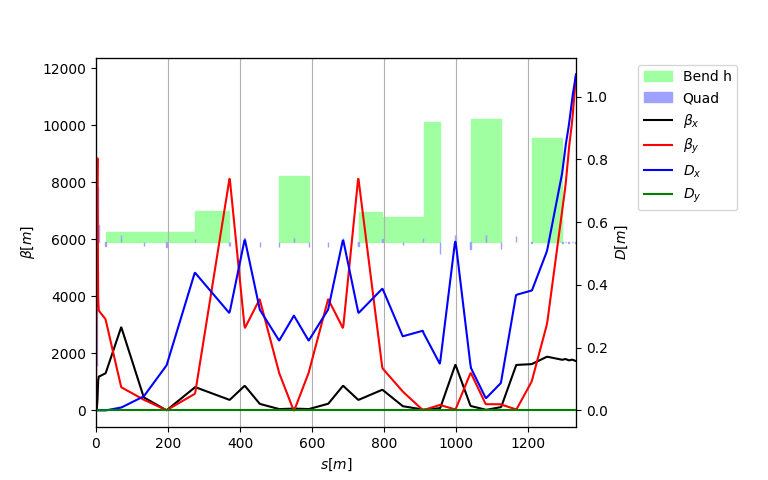

In [19]:
pp = opt_sfx1l_cd.plot()

In [20]:
# Imag 4 without r matrix
opt_imag4 = opt_sfx1l_cd.clone(name='imag4',
                                 add_targets=xt.TargetSet(betx=xt.LessThan(20), bety=xt.LessThan(25.),
                                         alfx=0, alfy=env['delta_alfy_ccsx'],
                                         dx=xt.GreaterThan(2e-3),
                                         dpx=env['dpx_ccxl'],
                                         at='ipimag4'))
opt = opt_imag4
opt.step(200)

# Focus on optics at sextupole
opt.disable(target=True)
opt.enable(target='sfx1l.*')

                                             
Optimize [imag4] - start penalty: 200.4 
Matching: model call n. 2016               
Optimize [imag4] - end penalty:  3.76131


In [21]:
opt.step(200)


                                             
Optimize [imag4] - start penalty: 2.915    
Matching: model call n. 2049               
Optimize [imag4] - end penalty:  2.4896e-10


In [22]:

opt_imag4 = opt_sfx1l_cd.clone(name='imag4',
            add_vary=opt_rsext.vary,
            add_targets=list(opt_rsext.targets) + 
                 [xt.TargetSet(betx=xt.LessThan(20), bety=xt.LessThan(25.),
                     alfx=0, alfy=env['delta_alfy_ccsx'],
                     dx=xt.GreaterThan(2e-3),
                     dpx=env['dpx_ccxl'],
                     at='ipimag4')] 
)
opt = opt_imag4

In [23]:
opt.step(20)

                                             
Optimize [imag4] - start penalty: 11.99 
Matching: model call n. 261               
Optimize [imag4] - end penalty:  0.015019


In [24]:
opt.run_simplex(1000)

                                             
Optimize [imag4] - start penalty: 0.01502 
Matching: model call n. 1888               1e-05              
Optimize [imag4] - end penalty:  0.00692899


In [25]:
opt.targets['ipimag4_dx'].weight = 10000
opt.targets['ipimag4_dpx'].weight = 1e6
opt.targets['sfx1l::1_mux'].weight = 10000
opt.step(20)

                                             
Optimize [imag4] - start penalty: 4.282    
Matching: model call n. 2145               
Optimize [imag4] - end penalty:  0.0108986


In [26]:
opt.target_mismatch()

Target mismatch:                           
id state tag           tol_met       residue   current_val target_val         description                                 
4  ON    sfm2l::0_dx     False  -9.85694e-05      0.234901 GreaterThan(0.235) ('dx', 'sfm2l::0'), val=GreaterThan(0.23 ...
9  ON    sfx1l::1_alfx   False   1.73758e-07   1.73758e-07 0                  ('alfx', 'sfx1l::1'), val=0, tol=1e-09,  ...
10 ON    sfx1l::1_mux    False  -8.54659e-09        1.7407 1.7407             ('mux', 'sfx1l::1'), val=1.7407, tol=1e- ...
12 ON                    False     -2.71e-08            -1 -1                 r11(sfx1l::1, sfx2l::1, val=-1, tol=1e-0 ...
13 ON                    False   2.11881e-07    -0.0999998 -0.1               r12(sfx1l::1, sfx2l::1, val=-0.1, tol=1e ...
14 ON                    False   0.000217467     -0.999783 -1                 r33(sfx1l::1, sfx2l::1, val=-1, tol=1e-0 ...
15 ON                    False  -1.19314e-06  -1.19314e-06 0.0                r34(sfx1l::1, sfx

In [27]:
opt.run_simplex(1000)

                                             
Optimize [imag4] - start penalty: 0.0109   
Matching: model call n. 3700               3e-06              
Optimize [imag4] - end penalty:  0.00101629


In [28]:
opt.target_mismatch()

Target mismatch:                           
id state tag           tol_met       residue   current_val target_val         description                                 
4  ON    sfm2l::0_dx     False  -9.90971e-05      0.234901 GreaterThan(0.235) ('dx', 'sfm2l::0'), val=GreaterThan(0.23 ...
9  ON    sfx1l::1_alfx   False  -5.15134e-08  -5.15134e-08 0                  ('alfx', 'sfx1l::1'), val=0, tol=1e-09,  ...
12 ON                    False  -2.66808e-08            -1 -1                 r11(sfx1l::1, sfx2l::1, val=-1, tol=1e-0 ...
13 ON                    False   1.35439e-07    -0.0999999 -0.1               r12(sfx1l::1, sfx2l::1, val=-0.1, tol=1e ...
14 ON                    False   0.000217478     -0.999783 -1                 r33(sfx1l::1, sfx2l::1, val=-1, tol=1e-0 ...
15 ON                    False   1.02662e-05   1.02662e-05 0.0                r34(sfx1l::1, sfx2l::1, val=0.0, tol=1e- ...
18 ON    ipimag4_alfx    False   5.74676e-06   5.74676e-06 0                  ('alfx', 'ipimag4

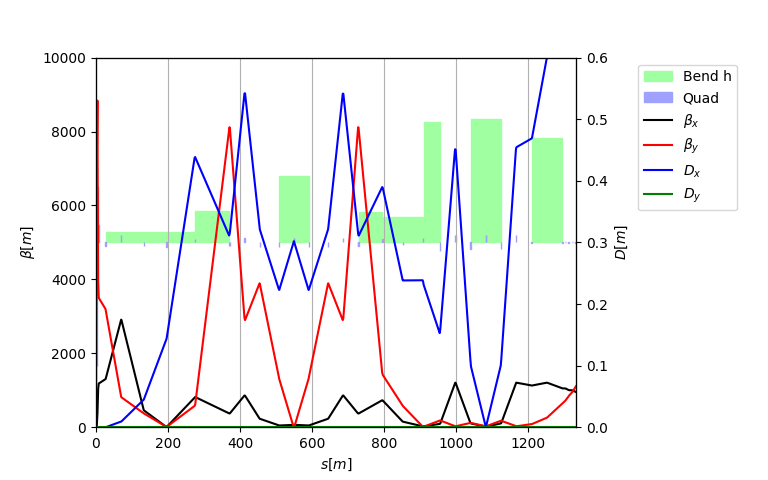

In [29]:
pp=opt.plot()
pp.ylim(left_lo=0, left_hi=10000, right_lo=0, right_hi=.6)

In [30]:
# Try to close with downstream quadrupoles alone
opt_end = opt_imag4.clone(
    name='end',
    remove_vary=True,
    remove_targets=True,
    add_vary=xt.VaryList(kq_section_e, step=1e-10),
    add_targets=[xt.TargetSet(
                       betx=env['bx_ff_out'], alfx=0.0,
                       bety=env['by_ff_out'], alfy = 0.0,
                       dx=env['dx_ff_out'], dpx=0.0,
                       mux=3.0, muy=2.75, at=xt.END),
                 xt.TargetSet(dx=0, dpx=0, at='qf17l'), # to prevent dx going wild in the straight
                 xt.TargetSet(dx=0, dpx=0, at='qd18l'), # to prevent dx going wild in the straight
                 xt.TargetSet(bety=xt.LessThan(2000), at='qf17l'),
                 xt.TargetSet(bety=xt.LessThan(2000), at='qd18l'),
                 xt.TargetSet(bety=xt.LessThan(2000), at='qf19l'),
                 xt.TargetSet(bety=xt.LessThan(2000), at='qd20l'),
                 xt.TargetSet(bety=xt.GreaterThan(750), at='qf19l'),
    ]
)
opt = opt_end

In [31]:
opt.step(10)

                                             
Optimize [end] - start penalty: 1016    
Matching: model call n. 123               
Optimize [end] - end penalty:  195.864


In [32]:
opt.targets['END_dx'].weight = 100
opt.targets['END_dpx'].weight = 100

In [33]:
opt.step(20)
opt.run_simplex(10000)

                                             
Optimize [end] - start penalty: 196.3     
Matching: model call n. 373               
Optimize [end] - end penalty:  7.50528
                                             
Optimize [end] - start penalty: 7.505     
Matching: model call n. 6795               95                
Optimize [end] - end penalty:  0.411693


In [34]:
opt_full = opt_end.clone(
    name='full',
    add_targets=opt_imag4.targets,
    add_vary=opt_imag4.vary
)
opt=opt_full

In [35]:
opt.targets['END_mux'].weight = 10000
opt.targets['END_muy'].weight = 10000
opt.targets['END_dpx'].weight = 10000

In [36]:
opt.run_simplex()

                                             
Optimize [full] - start penalty: 410.3  
Matching: model call n. 1458               3                 
Optimize [full] - end penalty:  4.10435


In [38]:
opt.run_simplex(10000)

                                             
Optimize [full] - start penalty: 4.104     
Matching: model call n. 14829               04629              
Optimize [full] - end penalty:  0.0213381


In [40]:
opt.target_mismatch()

Target mismatch:                            
id state tag           tol_met       residue   current_val target_val         description                                 
0  ON    END_betx        False  -0.000342509       66.6667 66.667             ('betx', '_end_point'), val=66.667, tol= ...
1  ON    END_bety        False   0.000757722          1600 1600.0             ('bety', '_end_point'), val=1600, tol=1e ...
2  ON    END_alfx        False  -8.47441e-05  -8.47441e-05 0.0                ('alfx', '_end_point'), val=0, tol=1e-09 ...
3  ON    END_alfy        False  -3.68107e-05  -3.68107e-05 0.0                ('alfy', '_end_point'), val=0, tol=1e-09 ...
4  ON    END_mux         False   4.53484e-08             3 3.0                ('mux', '_end_point'), val=3, tol=1e-09, ...
5  ON    END_muy         False   5.71631e-08          2.75 2.75               ('muy', '_end_point'), val=2.75, tol=1e- ...
6  ON    END_dx          False  -2.10566e-06  -2.10566e-06 0.0                ('dx', '_end_poi

In [41]:
opt.reload(0)

In [ ]:
opt.run_simplex(10000)

                                             
Optimize [full] - start penalty: 0.009848   
